In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
import mne
from mne.datasets import sample
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)

mne_erp_loc = 'E:/workspace/Trust_Data_and_Results/Haoming/varibility/data/mne_erp_exp1/'

In [2]:

bad_subject = np.array([3, 5, 15]) -1
all_subject = np.arange(0,34,1)


good_subject = np.setdiff1d(all_subject, bad_subject)

In [12]:
# Set the decoding model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# clf = make_pipeline(  CSP(n_components=3, norm_trace=False), LinearModel(LogisticRegression(solver='lbfgs')))
clf = make_pipeline(StandardScaler(), Vectorizer(),  LinearModel(LinearDiscriminantAnalysis(solver='svd')))
# clf = make_pipeline(StandardScaler(), Vectorizer(),  LinearModel(sklearn.svm.SVC(kernel='linear', probability=True)))

time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc', verbose=True)
cv = StratifiedShuffleSplit(100, test_size=0.10)

# cv = KFold(n_splits=5)

In [ ]:
# We will train the classifier on all left visual vs auditory trials on MEG

all_scores = []
all_patterns_coef = []
all_filters_coef = []

for iter_subject in good_subject:
    # iter_subject = 1
    subject_file = mne_erp_loc + '/subject_' + str(iter_subject + 1)

    eeg_epochs = mne.read_epochs(subject_file + '/alpha_epo.fif', preload = True)
    # eeg_epochs.set_montage(mymontage)
    eeg_epochs.resample(sfreq=50)

    # extract EEG data
    X = eeg_epochs.get_data()[:,25:85]  # EEG signals: n_epochs, n_eeg_channels, n_times
    y = eeg_epochs.events[:, 2]  # event: Trust or Untrust

    iter_subject_scores = []
    iter_subject_filters_coef = []
    iter_subject_patterns_coef = []

    for train_index, test_index in cv.split(X=X, y=y):
        # print(train_index, test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # fit the model
        time_decod.fit(X_train, y_train)

        scores = time_decod.score(X_test, y_test)
        # filters_coef = get_coef(time_decod, inverse_transform=True)
        # filters_coef = get_coef(time_decod, 'filters_', inverse_transform=True)
        # patterns_coef = get_coef(time_decod, 'patterns_', inverse_transform=True)

        iter_subject_scores.append(scores)
        # iter_subject_filters_coef.append(filters_coef)
        # iter_subject_patterns_coef.append(patterns_coef)

    iter_subject_scores_average = np.mean(iter_subject_scores,axis=0)
    # iter_subject_filters_coef_average = np.mean(iter_subject_filters_coef,axis=0)
    # iter_subject_patterns_coef_average = np.mean(iter_subject_patterns_coef,axis=0)

    all_scores.append(iter_subject_scores_average)
    # all_filters_coef.append(iter_subject_filters_coef_average)
    # all_patterns_coef.append(iter_subject_patterns_coef_average)

In [16]:
np.save(r'E:\workspace\Trust_Data_and_Results\Haoming\varibility\result\MVPA_result\alpha_svm_mvpa_region1_2_20ms.npy', all_scores)

In [3]:
all_scores = np.load(r'E:\workspace\Trust_Data_and_Results\Haoming\varibility\result\MVPA_result\alpha_svm_mvpa_region1_2_20ms.npy')

In [23]:
behaviorVar_loc = 'E:/workspace/Trust_Data_and_Results/Haoming/varibility/behavior_result/behavior_varibility.npy'
behavior_varibility = np.load(behaviorVar_loc)

behavior_varibility.shape
behavior_varibility = behavior_varibility[good_subject]
print(behavior_varibility.shape)

(31, 4)


In [17]:
# permutation test 
from hm_tools import *
import os
n_permutations=10000
permutation_cluster_result = {}

all_scores = np.array(all_scores)

permu_result_loc = 'E:/workspace/Trust_Data_and_Results/Haoming/varibility/result/MVPA_result/'

permutation_cluster_result = hm_perm_clus_1samp_test(input_matrix=all_scores, baseline=0.5, n_permutations=n_permutations)

if not os.path.exists(permu_result_loc):
    os.makedirs(permu_result_loc)
np.save(permu_result_loc + 'mvpa_permu_result_20ms' + '.npy', permutation_cluster_result)

Using a threshold of 2.042272
stat_fun(H1): min=-1.980791 max=2.807912
Running initial clustering
Found 4 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:03<00:00, 3030.72it/s]

Computing cluster p-values
Done.


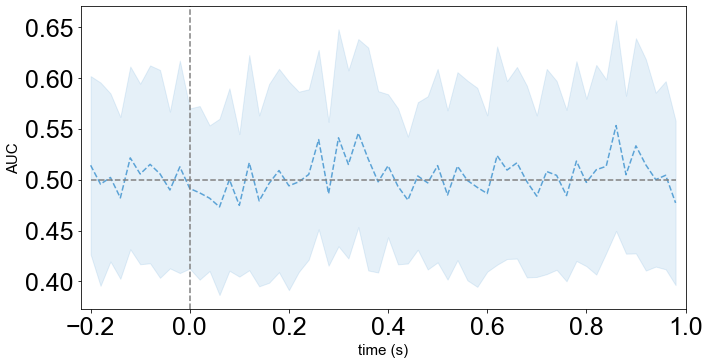

In [7]:
# plot MVPA result
import matplotlib.pyplot as plt
from matplotlib import font_manager
from hm_tools import *
permu_result_loc = 'E:/workspace/Trust_Data_and_Results/Haoming/varibility/result/MVPA_result/'

plot_result_loc = permu_result_loc
# permutation_cluster_result = np.load(permu_result_loc + 'all_event_0_1_alpha' + '.npy', allow_pickle=True).item()
figsize=(12,6)
title_size = 20
labelsize = 15
ticksize=25
# fontProperties = font_manager.FontProperties(fname='C:/Windows/Fonts/arial.ttf')
times = np.arange(-0.2, 1, 0.02)

permutation_cluster_result = np.load(permu_result_loc + 'mvpa_permu_result_20ms' + '.npy', allow_pickle=True).item()

if not os.path.exists(plot_result_loc):
    os.makedirs(plot_result_loc)


plt.close('all')
# set figure_size
plt.rcParams['figure.figsize'] = figsize # 设置figure_size尺寸

# calculate mean and std
all_scores_std = np.std(all_scores, axis=0)
all_scores_mean= np.average(all_scores, axis=0)

# use my function to plot
plt = hm_plot_1samp_erp(plt,permutation_cluster_result, all_scores_mean, 
                all_scores_std, times, ticksize = ticksize,
                line_color='#0070C0', dotline_alpha = 0.6)

plt.xlabel("time (s)", fontsize=labelsize, family='Arial')
plt.ylabel("AUC", fontsize=labelsize, family='Arial')

plt.axvline(times[10], c="gray", ls = "dashed")
plt.plot(times, np.ones(len(times))/2, color="gray", linestyle="dashed")
